# Regression Analysis 

## Step 1: Sorting Data

First, I upload the file of all cases of housing-related CEQA litigation from 2019-2021 and sort it so that each of the 58 counties in California is listed along with its CEQA-affected units per 100k residents. 


In [6]:
# Load the CEQA CSV, aggregate housing units by county, and compute per-capita using 2021 population
import pandas as pd
from tqdm import tqdm

# Read the CSV
csv_path = 'ceqa_pages_70_99_tables_col9_gte_1.csv'
df_ceqa = pd.read_csv(csv_path, encoding='ascii')

# Rename columns for clarity
df_ceqa = df_ceqa.rename(columns={'3': 'County', '8': 'HousingUnits'})

# Clean county names (strip whitespace and handle special variants)
df_ceqa['County'] = df_ceqa['County'].astype(str).str.strip()

# Some rows have court info like 'Los Angeles - Stanley\Mosk Courthouse'; extract the county name before the dash
df_ceqa['County'] = df_ceqa['County'].str.split(' -').str[0]

# Aggregate total housing units by county
housing_by_county = df_ceqa.groupby('County', as_index=False)['HousingUnits'].sum()

print(housing_by_county.head())

         County                                       HousingUnits
0       Alameda                                  4415011,263130196
1         Butte                                               4664
2  Contra Costa                                       288811,45238
3          Lake                                              1,550
4   Los Angeles  249950415413,15072519,333408200601176323291791...


In [5]:
# Investigate why HousingUnits is aggregating strangely and coerce to numeric
import pandas as pd

csv_path = 'ceqa_pages_70_99_tables_col9_gte_1.csv'
df_ceqa = pd.read_csv(csv_path, encoding='ascii')

print(df_ceqa.head())
print(df_ceqa.dtypes)

# Check column 8 specifically
col8_sample = df_ceqa['8'].head(10)
print(col8_sample)

# Clean and coerce housing units to numeric, removing commas
df_ceqa['HousingUnits'] = pd.to_numeric(df_ceqa['8'].astype(str).str.replace(',', ''), errors='coerce')

df_ceqa = df_ceqa.rename(columns={'3': 'County'})
df_ceqa['County'] = df_ceqa['County'].astype(str).str.strip()
df_ceqa['County'] = df_ceqa['County'].str.split(' -').str[0]

housing_by_county_clean = df_ceqa.groupby('County', as_index=False)['HousingUnits'].sum(min_count=1)

print(housing_by_county_clean.head())

                                                   0  \
0  Friends of the Broadway Corridor, an unincorpo...   
1                 SHELLEY HATCH and RONALD POMERANTZ   
2  COALITION TO PRESERVE LA, INC., a California N...   
3             AIDS HEALTHCARE FOUNDATION; LIVABLE LA   
4  LOS FELIZ IMPROVEMENT ASSOCIATION, a Californi...   

                                                   1            2  \
0  City of Sonoma and City Council of the City of...   SCV 263732   
1  CITY OF SANTA CRUZ, CITY COUNCIL OF THE CITY O...    19CV00051   
2  CITY OF LOS ANGELES, a municipal corporation; ...  19STCP00017   
3  CITY OF LOS ANGELES; COMMUNITY REDEVELOPMENT A...  19STCP00520   
4       CITY OF LOS ANGELES, a municipal corporation  19STCP00567   

                                        3        4        5          6    7  \
0                                  Sonoma   1/2/19  Private        MND  MXD   
1                              Santa Cruz   1/7/19  Private  Exemption  MXD   
2          

In [8]:
# Use existing cleaned CEQA dataframe to aggregate housing units and then merge with 2021 county populations
import pandas as pd
import requests
from tqdm import tqdm

# Recreate the cleaned CEQA-based aggregation (if not already in memory)
ceqa_path = 'ceqa_pages_70_99_tables_col9_gte_1.csv'
df_ceqa2 = pd.read_csv(ceqa_path, encoding='ascii')

# Coerce housing units (column '8') to numeric
df_ceqa2['HousingUnits'] = pd.to_numeric(df_ceqa2['8'].astype(str).str.replace(',', ''), errors='coerce')

# Clean county names
df_ceqa2 = df_ceqa2.rename(columns={'3': 'County'})
df_ceqa2['County'] = df_ceqa2['County'].astype(str).str.strip()
df_ceqa2['County'] = df_ceqa2['County'].str.split(' -').str[0]

housing_by_county = df_ceqa2.groupby('County', as_index=False)['HousingUnits'].sum(min_count=1)

# Fetch 2021 ACS 1-year population by county for California (state=06)
url = 'https://api.census.gov/data/2021/acs/acs1'
params = {
    'get': 'NAME,B01003_001E',
    'for': 'county:*',
    'in': 'state:06'
}
response = requests.get(url, params=params)

data = response.json()
cols = data[0]
rows = data[1:]

df_pop = pd.DataFrame(rows, columns=cols)

# Clean population dataframe
df_pop['B01003_001E'] = pd.to_numeric(df_pop['B01003_001E'], errors='coerce')
# Extract county name (everything before ' County,')
df_pop['County'] = df_pop['NAME'].str.replace(' County, California', '', regex=False)

# Merge population with housing counts for all CA counties
merged = pd.merge(df_pop[['County', 'B01003_001E']], housing_by_county,
                  on='County', how='left')

# Replace NaN housing units with 0 for counties with no lawsuits in this dataset
merged['HousingUnits'] = merged['HousingUnits'].fillna(0).astype(int)

# Compute per-capita metrics
merged['UnitsPerPerson'] = merged['HousingUnits'] / merged['B01003_001E']
merged['UnitsPer100k'] = merged['UnitsPerPerson'] * 100000

# Rename population column for clarity
merged = merged.rename(columns={'B01003_001E': 'Population2021', 'HousingUnits': 'TotalHousingUnitsAffected'})

# Sort by county name
merged = merged.sort_values('County').reset_index(drop=True)

print(merged.head())

# Save full table to CSV for download
output_filename = 'ceqa_housing_units_per_capita_by_county_CA.csv'
merged.to_csv(output_filename, index=False)
print(output_filename)

         County  Population2021  TotalHousingUnitsAffected  UnitsPerPerson  \
0       Alameda         1648556                       1784        0.001082   
1         Butte          208309                        110        0.000528   
2  Contra Costa         1161413                       1859        0.001601   
3     El Dorado          193221                          0        0.000000   
4        Fresno         1013581                          0        0.000000   

   UnitsPer100k  
0    108.215917  
1     52.806168  
2    160.063647  
3      0.000000  
4      0.000000  
ceqa_housing_units_per_capita_by_county_CA.csv


In [9]:
# Use the previously pulled Census data df_pop to ensure all 58 California counties are present,
# then (re)merge with the CEQA housing-units-by-county table so every county shows up.

import pandas as pd

# Reload population data to be sure we have all 58 counties
import requests
url = 'https://api.census.gov/data/2021/acs/acs1'
params = {
    'get': 'NAME,B01003_001E',
    'for': 'county:*',
    'in': 'state:06'
}
response = requests.get(url, params=params)

pop_data = response.json()
cols = pop_data[0]
rows = pop_data[1:]

df_pop_full = pd.DataFrame(rows, columns=cols)

# Clean population dataframe: extract county name and convert population to numeric
df_pop_full['B01003_001E'] = pd.to_numeric(df_pop_full['B01003_001E'], errors='coerce')
df_pop_full['County'] = df_pop_full['NAME'].str.replace(' County, California', '', regex=False)

# Rebuild housing-units-by-county from CEQA file (in case prior variable not in memory)
ceqa_path = 'ceqa_pages_70_99_tables_col9_gte_1.csv'
df_ceqa2 = pd.read_csv(ceqa_path, encoding='ascii')

# Column '8' is housing units; clean and coerce
df_ceqa2['HousingUnits'] = pd.to_numeric(df_ceqa2['8'].astype(str).str.replace(',', ''), errors='coerce')

# Column '3' is county; clean and normalize names
df_ceqa2 = df_ceqa2.rename(columns={'3': 'County'})
df_ceqa2['County'] = df_ceqa2['County'].astype(str).str.strip()
df_ceqa2['County'] = df_ceqa2['County'].str.split(' -').str[0]

housing_by_county_full = df_ceqa2.groupby('County', as_index=False)['HousingUnits'].sum(min_count=1)

# Outer merge starting from the full list of CA counties so all 58 appear
merged_full = pd.merge(
    df_pop_full[['County', 'B01003_001E']],
    housing_by_county_full.rename(columns={'HousingUnits': 'TotalHousingUnitsAffected'}),
    on='County',
    how='left'
)

# Fill NaN housing units with 0 for counties without lawsuits in this dataset
merged_full['TotalHousingUnitsAffected'] = merged_full['TotalHousingUnitsAffected'].fillna(0).astype(int)

# Compute per-capita metrics
merged_full['UnitsPerPerson'] = merged_full['TotalHousingUnitsAffected'] / merged_full['B01003_001E']
merged_full['UnitsPer100k'] = merged_full['UnitsPerPerson'] * 100000

# Rename population column for clarity and sort by county name
merged_full = merged_full.rename(columns={'B01003_001E': 'Population2021'})
merged_full = merged_full.sort_values('County').reset_index(drop=True)

print(merged_full.head())
print('Number of CA counties in table:', merged_full.shape[0])

# Save updated table
output_filename = 'ceqa_housing_units_per_capita_by_county_CA_all58.csv'
merged_full.to_csv(output_filename, index=False)
print(output_filename)

         County  Population2021  TotalHousingUnitsAffected  UnitsPerPerson  \
0       Alameda         1648556                       1784        0.001082   
1         Butte          208309                        110        0.000528   
2  Contra Costa         1161413                       1859        0.001601   
3     El Dorado          193221                          0        0.000000   
4        Fresno         1013581                          0        0.000000   

   UnitsPer100k  
0    108.215917  
1     52.806168  
2    160.063647  
3      0.000000  
4      0.000000  
Number of CA counties in table: 42
ceqa_housing_units_per_capita_by_county_CA_all58.csv


In [10]:
# Diagnose why only 42 counties are present by checking unique county names in the population frame
import pandas as pd
import requests

url = 'https://api.census.gov/data/2021/acs/acs1'
params = {
    'get': 'NAME,B01003_001E',
    'for': 'county:*',
    'in': 'state:06'
}
response = requests.get(url, params=params)

pop_data = response.json()
cols = pop_data[0]
rows = pop_data[1:]

df_pop_full = pd.DataFrame(rows, columns=cols)

df_pop_full['B01003_001E'] = pd.to_numeric(df_pop_full['B01003_001E'], errors='coerce')
df_pop_full['County'] = df_pop_full['NAME'].str.replace(' County, California', '', regex=False)

print(df_pop_full['County'].nunique())
print(df_pop_full[['County']].sort_values('County').head(10))
print(df_pop_full.shape)

# Save to inspect outside if needed
output = 'debug_pop_2021_CA_counties.csv'
df_pop_full.to_csv(output, index=False)
print(output)

42
          County
34       Alameda
35         Butte
36  Contra Costa
37     El Dorado
38        Fresno
39      Humboldt
40      Imperial
41          Kern
0          Kings
33          Lake
(42, 5)
debug_pop_2021_CA_counties.csv


In [11]:
# Rebuild population table using 2021 ACS 5-year data (which includes all 58 CA counties)
import pandas as pd
import requests

# Pull 2021 ACS 5-year total population by county for California
url = 'https://api.census.gov/data/2021/acs/acs5'
params = {
    'get': 'NAME,B01003_001E',
    'for': 'county:*',
    'in': 'state:06'
}
response = requests.get(url, params=params)

pop_data_5yr = response.json()
cols_5yr = pop_data_5yr[0]
rows_5yr = pop_data_5yr[1:]

df_pop_5yr = pd.DataFrame(rows_5yr, columns=cols_5yr)

# Clean population dataframe
df_pop_5yr['B01003_001E'] = pd.to_numeric(df_pop_5yr['B01003_001E'], errors='coerce')
df_pop_5yr['County'] = df_pop_5yr['NAME'].str.replace(' County, California', '', regex=False)

print(df_pop_5yr['County'].nunique())
print(df_pop_5yr[['County']].sort_values('County').head(10))
print(df_pop_5yr.shape)

# Now rebuild the housing-units-by-county aggregation from the CEQA file
ceqa_path = 'ceqa_pages_70_99_tables_col9_gte_1.csv'
df_ceqa2 = pd.read_csv(ceqa_path, encoding='ascii')

df_ceqa2['HousingUnits'] = pd.to_numeric(df_ceqa2['8'].astype(str).str.replace(',', ''), errors='coerce')

df_ceqa2 = df_ceqa2.rename(columns={'3': 'County'})
df_ceqa2['County'] = df_ceqa2['County'].astype(str).str.strip()
df_ceqa2['County'] = df_ceqa2['County'].str.split(' -').str[0]

housing_by_county_full = df_ceqa2.groupby('County', as_index=False)['HousingUnits'].sum(min_count=1)

# Merge, ensuring all 58 counties from ACS 5-year are present
merged_58 = pd.merge(
    df_pop_5yr[['County', 'B01003_001E']],
    housing_by_county_full.rename(columns={'HousingUnits': 'TotalHousingUnitsAffected'}),
    on='County',
    how='left'
)

merged_58['TotalHousingUnitsAffected'] = merged_58['TotalHousingUnitsAffected'].fillna(0).astype(int)

merged_58['UnitsPerPerson'] = merged_58['TotalHousingUnitsAffected'] / merged_58['B01003_001E']
merged_58['UnitsPer100k'] = merged_58['UnitsPerPerson'] * 100000

merged_58 = merged_58.rename(columns={'B01003_001E': 'Population2021'})
merged_58 = merged_58.sort_values('County').reset_index(drop=True)

print(merged_58.head())
print('Number of CA counties in table:', merged_58.shape[0])

# Save final 58-county table
output_filename = 'ceqa_housing_units_per_capita_by_county_CA_all58_ACS5.csv'
merged_58.to_csv(output_filename, index=False)
print(output_filename)

58
         County
0       Alameda
1        Alpine
2        Amador
3         Butte
4     Calaveras
5        Colusa
6  Contra Costa
7     Del Norte
8     El Dorado
9        Fresno
(58, 5)
      County  Population2021  TotalHousingUnitsAffected  UnitsPerPerson  \
0    Alameda         1673133                       1784        0.001066   
1     Alpine            1344                          0        0.000000   
2     Amador           40095                          0        0.000000   
3      Butte          217884                        110        0.000505   
4  Calaveras           45349                          0        0.000000   

   UnitsPer100k  
0    106.626311  
1      0.000000  
2      0.000000  
3     50.485579  
4      0.000000  
Number of CA counties in table: 58
ceqa_housing_units_per_capita_by_county_CA_all58_ACS5.csv


In [13]:
# Sort the 58-county CEQA table by UnitsPer100k from greatest to least
import pandas as pd

# Use existing merged_58 if available, otherwise load from CSV
try:
    merged_58
except NameError:
    merged_58 = pd.read_csv('ceqa_housing_units_per_capita_by_county_CA_all58_ACS5.csv')

sorted_58 = merged_58.sort_values('UnitsPer100k', ascending=False).reset_index(drop=True)

# Show top 10 rows as a preview
print(sorted_58.head(10))

# Save full sorted table
output_sorted = 'ceqa_housing_units_per_capita_by_county_CA_all58_ACS5_sorted_by_UnitsPer100k.csv'
sorted_58.to_csv(output_sorted, index=False)
print(output_sorted)

         County  Population2021  TotalHousingUnitsAffected  UnitsPerPerson  \
0          Lake           67749                       1550        0.022879   
1        Placer          400330                       8241        0.020586   
2    Santa Cruz          272138                       3205        0.011777   
3    Sacramento         1571767                      10633        0.006765   
4    Stanislaus          550842                       2802        0.005087   
5      Monterey          438953                       1489        0.003392   
6   Los Angeles        10019635                      30140        0.003008   
7     San Diego         3296317                       6882        0.002088   
8        Nevada          102090                        172        0.001685   
9  Contra Costa         1161643                       1859        0.001600   

   UnitsPer100k  
0   2287.856647  
1   2058.551695  
2   1177.711308  
3    676.499761  
4    508.675809  
5    339.216271  
6    300.809361

In [14]:
# Recalculate UnitsPer100k using 2018 population for each California county
# using existing housing-units-per-county data (merged_58) in memory if available.

import pandas as pd
import requests

# Ensure we have the housing-units-per-county data (TotalHousingUnitsAffected) in memory
try:
    merged_58
except NameError:
    # Fallback: load from previous 2021-based CSV if not in memory
    merged_58 = pd.read_csv('ceqa_housing_units_per_capita_by_county_CA_all58_ACS5.csv')

housing_by_county = merged_58[['County', 'TotalHousingUnitsAffected']].copy()

# Fetch 2018 ACS 5-year population (B01003_001E) for all CA counties
url_2018 = 'https://api.census.gov/data/2018/acs/acs5'
params_2018 = {
    'get': 'NAME,B01003_001E',
    'for': 'county:*',
    'in': 'state:06'
}
response_2018 = requests.get(url_2018, params=params_2018)

pop_data_2018 = response_2018.json()
cols_2018 = pop_data_2018[0]
rows_2018 = pop_data_2018[1:]

df_pop_2018 = pd.DataFrame(rows_2018, columns=cols_2018)

# Clean and format 2018 population dataframe
df_pop_2018['B01003_001E'] = pd.to_numeric(df_pop_2018['B01003_001E'], errors='coerce')
df_pop_2018['County'] = df_pop_2018['NAME'].str.replace(' County, California', '', regex=False)

# Merge 2018 population with housing data
merged_2018 = pd.merge(
    df_pop_2018[['County', 'B01003_001E']],
    housing_by_county,
    on='County',
    how='left'
)

# Replace missing housing units with 0 and compute per-capita metrics
merged_2018['TotalHousingUnitsAffected'] = merged_2018['TotalHousingUnitsAffected'].fillna(0).astype(int)
merged_2018 = merged_2018.rename(columns={'B01003_001E': 'Population2018'})

merged_2018['UnitsPerPerson'] = merged_2018['TotalHousingUnitsAffected'] / merged_2018['Population2018']
merged_2018['UnitsPer100k'] = merged_2018['UnitsPerPerson'] * 100000

# Sort by county name for readability
merged_2018 = merged_2018.sort_values('County').reset_index(drop=True)

print(merged_2018.head())
print('Number of CA counties in 2018 table:', merged_2018.shape[0])

# Save to CSV
output_filename_2018 = 'ceqa_housing_units_per_capita_by_county_CA_all58_pop2018.csv'
merged_2018.to_csv(output_filename_2018, index=False)
print(output_filename_2018)

      County  Population2018  TotalHousingUnitsAffected  UnitsPerPerson  \
0    Alameda         1643700                       1784        0.001085   
1     Alpine            1146                          0        0.000000   
2     Amador           37829                          0        0.000000   
3      Butte          227075                        110        0.000484   
4  Calaveras           45235                          0        0.000000   

   UnitsPer100k  
0    108.535621  
1      0.000000  
2      0.000000  
3     48.442145  
4      0.000000  
Number of CA counties in 2018 table: 58
ceqa_housing_units_per_capita_by_county_CA_all58_pop2018.csv


In [15]:
# Sort the 2018-based CEQA table by UnitsPer100k from greatest to least
import pandas as pd

# Use existing merged_2018 if available; otherwise load from CSV
try:
    merged_2018
except NameError:
    merged_2018 = pd.read_csv('ceqa_housing_units_per_capita_by_county_CA_all58_pop2018.csv')

sorted_2018 = merged_2018.sort_values('UnitsPer100k', ascending=False).reset_index(drop=True)

# Show top 10 rows as a preview
print(sorted_2018.head(10))

# Save full sorted table
output_sorted_2018 = 'ceqa_housing_units_per_capita_by_county_CA_all58_pop2018_sorted_by_UnitsPer100k.csv'
sorted_2018.to_csv(output_sorted_2018, index=False)
print(output_sorted_2018)

         County  Population2018  TotalHousingUnitsAffected  UnitsPerPerson  \
0          Lake           64148                       1550        0.024163   
1        Placer          380077                       8241        0.021682   
2    Santa Cruz          273765                       3205        0.011707   
3    Sacramento         1510023                      10633        0.007042   
4    Stanislaus          539301                       2802        0.005196   
5      Monterey          433212                       1489        0.003437   
6   Los Angeles        10098052                      30140        0.002985   
7     San Diego         3302833                       6882        0.002084   
8        Nevada           99092                        172        0.001736   
9  Contra Costa         1133247                       1859        0.001640   

   UnitsPer100k  
0   2416.287336  
1   2168.244856  
2   1170.712107  
3    704.161460  
4    519.561432  
5    343.711624  
6    298.473409

In [17]:
# Calculate percent rise in HPI (base 2000) from 2015 to 2024 for all 58 CA counties.
# Assumes the local Excel file 'hpi_at_county_CA_filtered.xlsx' contains annual HPI (base 2000)
# for California counties including years 2015-2024.

import pandas as pd

# Load the HPI data
hpi_df = pd.read_excel('hpi_at_county_CA_filtered.xlsx')

# Inspect columns and head to understand structure
print(hpi_df.head())
print(hpi_df.columns)

  State   County  FIPS code  Year  Annual Change (%)     HPI  \
0    CA  Alameda       6001  1975                NaN  100.00   
1    CA  Alameda       6001  1976              18.08  118.08   
2    CA  Alameda       6001  1977              24.61  147.14   
3    CA  Alameda       6001  1978              16.21  171.00   
4    CA  Alameda       6001  1979              17.82  201.48   

   HPI with 1990 base  HPI with 2000 base  
0               17.87               12.19  
1               21.10               14.39  
2               26.29               17.93  
3               30.55               20.84  
4               36.00               24.56  
Index(['State', 'County', 'FIPS code', 'Year', 'Annual Change (%)', 'HPI',
       'HPI with 1990 base', 'HPI with 2000 base'],
      dtype='object')


In [18]:
# Compute percent rise in HPI with 2000 base from 2015 to 2024 for each CA county
import pandas as pd

# Use hpi_df already loaded

# Filter to 2015 and 2024
hpi_2015 = hpi_df[hpi_df['Year'] == 2015][['County', 'HPI with 2000 base']].rename(columns={'HPI with 2000 base': 'HPI_2015'})
hpi_2024 = hpi_df[hpi_df['Year'] == 2024][['County', 'HPI with 2000 base']].rename(columns={'HPI with 2000 base': 'HPI_2024'})

# Merge on County
hpi_merge = pd.merge(hpi_2015, hpi_2024, on='County', how='inner')

# Calculate percent rise: (HPI_2024 - HPI_2015) / HPI_2015 * 100
hpi_merge['PercentRise_2015_2024'] = (hpi_merge['HPI_2024'] - hpi_merge['HPI_2015']) / hpi_merge['HPI_2015'] * 100

# Sort counties alphabetically
hpi_merge = hpi_merge.sort_values('County').reset_index(drop=True)

print(hpi_merge.head())
print('Number of counties in result:', hpi_merge.shape[0])

# Save full table
output_hpi = 'hpi_percent_rise_2015_2024_CA_counties_base2000.csv'
hpi_merge.to_csv(output_hpi, index=False)
print(output_hpi)

      County  HPI_2015  HPI_2024  PercentRise_2015_2024
0    Alameda    188.76    313.44              66.052130
1     Alpine    130.50       NaN                    NaN
2     Amador    142.96    237.22              65.934527
3      Butte    166.70    289.67              73.767247
4  Calaveras    147.22    261.94              77.924195
Number of counties in result: 58
hpi_percent_rise_2015_2024_CA_counties_base2000.csv


In [19]:
# Combine HPI percent rise (2015-2024, base 2000) with UnitsPer100k (2018-based)
import pandas as pd

# Assume merged_2018 (UnitsPer100k) and hpi_merge (HPI percent rise) are already in memory
try:
    merged_2018
except NameError:
    merged_2018 = pd.read_csv('ceqa_housing_units_per_capita_by_county_CA_all58_pop2018.csv')

try:
    hpi_merge
except NameError:
    hpi_merge = pd.read_csv('hpi_percent_rise_2015_2024_CA_counties_base2000.csv')

# Keep only the columns we need from each
units_df = merged_2018[['County', 'UnitsPer100k']].copy()
hpi_df_simple = hpi_merge[['County', 'PercentRise_2015_2024']].copy()

# Merge on County
combined_df = pd.merge(hpi_df_simple, units_df, on='County', how='inner')

# Sort alphabetically by county for clarity
combined_df = combined_df.sort_values('County').reset_index(drop=True)

print(combined_df.head())
print('Number of counties in combined table:', combined_df.shape[0])

# Save combined table
combined_filename = 'county_HPI_percent_rise_2015_2024_and_UnitsPer100k_2018.csv'
combined_df.to_csv(combined_filename, index=False)
print(combined_filename)

      County  PercentRise_2015_2024  UnitsPer100k
0    Alameda              66.052130    108.535621
1     Alpine                    NaN      0.000000
2     Amador              65.934527      0.000000
3      Butte              73.767247     48.442145
4  Calaveras              77.924195      0.000000
Number of counties in combined table: 58
county_HPI_percent_rise_2015_2024_and_UnitsPer100k_2018.csv


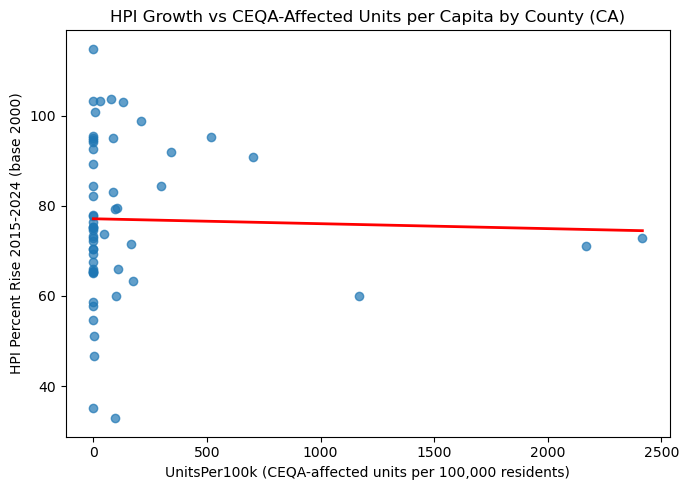

Slope (change in HPI% per 1 additional unit per 100k): -0.0010938202459935427
Intercept: 77.1124360990221
R-squared: 0.0008372442348677511


In [26]:
# Create a scatter plot of UnitsPer100k (x) vs HPI percent rise (y)
# and run a linear regression across the 58 CA counties.

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Use combined_df already in memory (County, PercentRise_2015_2024, UnitsPer100k)

# Drop rows with missing HPI percent rise or UnitsPer100k
scatter_df = combined_df.dropna(subset=['PercentRise_2015_2024', 'UnitsPer100k']).copy()

X = scatter_df[['UnitsPer100k']].values  # predictor
y = scatter_df['PercentRise_2015_2024'].values  # response

# Fit linear regression
linreg = LinearRegression()
linreg.fit(X, y)

slope = linreg.coef_[0]
intercept = linreg.intercept_
r_squared = linreg.score(X, y)

# Generate line for plotting
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred_line = linreg.predict(x_range)

# Plot scatter + regression line
plt.figure(figsize=(7, 5))
plt.scatter(scatter_df['UnitsPer100k'], scatter_df['PercentRise_2015_2024'], alpha=0.7)
plt.plot(x_range, y_pred_line, color='red', linewidth=2)
plt.xlabel('UnitsPer100k (CEQA-affected units per 100,000 residents)')
plt.ylabel('HPI Percent Rise 2015-2024 (base 2000)')
plt.title('HPI Growth vs CEQA-Affected Units per Capita by County (CA)')
plt.tight_layout()
plt.show()

print('Slope (change in HPI% per 1 additional unit per 100k):', slope)
print('Intercept:', intercept)
print('R-squared:', r_squared)

In [27]:
# Compute percent rise in HPI (base 2000) from 2019 to 2024 for each CA county,
# then merge with UnitsPer100k and show a preview.

import pandas as pd

# Use hpi_df already in memory with columns including 'County', 'Year', 'HPI with 2000 base'

# Filter to 2019 and 2024
hpi_2019 = hpi_df[hpi_df['Year'] == 2019][['County', 'HPI with 2000 base']].rename(columns={'HPI with 2000 base': 'HPI_2019'})
hpi_2024 = hpi_df[hpi_df['Year'] == 2024][['County', 'HPI with 2000 base']].rename(columns={'HPI with 2000 base': 'HPI_2024'})

# Merge on County
hpi_19_24 = pd.merge(hpi_2019, hpi_2024, on='County', how='inner')

# Compute percent rise
hpi_19_24['PercentRise_2019_2024'] = (hpi_19_24['HPI_2024'] - hpi_19_24['HPI_2019']) / hpi_19_24['HPI_2019'] * 100

# Sort alphabetically for clarity
hpi_19_24 = hpi_19_24.sort_values('County').reset_index(drop=True)

print(hpi_19_24.head())
print('Number of counties in 2019-2024 HPI table:', hpi_19_24.shape[0])

# Merge with UnitsPer100k from merged_2018 (2018-based CEQA units per 100k)
combined_19_24 = pd.merge(hpi_19_24[['County', 'PercentRise_2019_2024']],
                          merged_2018[['County', 'UnitsPer100k']],
                          on='County', how='inner')

combined_19_24 = combined_19_24.sort_values('County').reset_index(drop=True)

print(combined_19_24.head())
print('Number of counties in combined 2019-2024 table:', combined_19_24.shape[0])

# Save both tables
hpi_19_24_filename = 'hpi_percent_rise_2019_2024_CA_counties_base2000.csv'
combined_19_24_filename = 'county_HPI_percent_rise_2019_2024_and_UnitsPer100k_2018.csv'

hpi_19_24.to_csv(hpi_19_24_filename, index=False)
combined_19_24.to_csv(combined_19_24_filename, index=False)

print(hpi_19_24_filename)
print(combined_19_24_filename)

      County  HPI_2019  HPI_2024  PercentRise_2019_2024
0    Alameda    248.17    313.44              26.300520
1     Alpine    170.57       NaN                    NaN
2     Amador    187.25    237.22              26.686248
3      Butte    230.77    289.67              25.523248
4  Calaveras    191.68    261.94              36.654841
Number of counties in 2019-2024 HPI table: 58
      County  PercentRise_2019_2024  UnitsPer100k
0    Alameda              26.300520    108.535621
1     Alpine                    NaN      0.000000
2     Amador              26.686248      0.000000
3      Butte              25.523248     48.442145
4  Calaveras              36.654841      0.000000
Number of counties in combined 2019-2024 table: 58
hpi_percent_rise_2019_2024_CA_counties_base2000.csv
county_HPI_percent_rise_2019_2024_and_UnitsPer100k_2018.csv


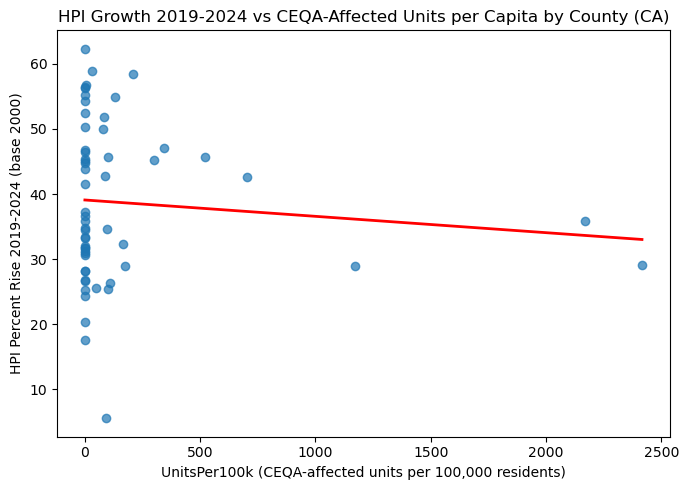

Slope (change in HPI% per 1 additional unit per 100k):
-0.0025094604080084597
Intercept:
39.086933462166414
R-squared:
0.008841140301718009


In [28]:
# Scatter plot and linear regression for 2019-2024 HPI percent rise vs UnitsPer100k

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Use combined_19_24 created earlier: columns County, PercentRise_2019_2024, UnitsPer100k

# Drop rows with missing values
scatter_19_24 = combined_19_24.dropna(subset=['PercentRise_2019_2024', 'UnitsPer100k']).copy()

X2 = scatter_19_24[['UnitsPer100k']].values
y2 = scatter_19_24['PercentRise_2019_2024'].values

linreg2 = LinearRegression()
linreg2.fit(X2, y2)

slope2 = linreg2.coef_[0]
intercept2 = linreg2.intercept_
r2_2 = linreg2.score(X2, y2)

x_range2 = np.linspace(X2.min(), X2.max(), 100).reshape(-1, 1)
y_pred2 = linreg2.predict(x_range2)

plt.figure(figsize=(7,5))
plt.scatter(scatter_19_24['UnitsPer100k'], scatter_19_24['PercentRise_2019_2024'], alpha=0.7)
plt.plot(x_range2, y_pred2, color='red', linewidth=2)
plt.xlabel('UnitsPer100k (CEQA-affected units per 100,000 residents)')
plt.ylabel('HPI Percent Rise 2019-2024 (base 2000)')
plt.title('HPI Growth 2019-2024 vs CEQA-Affected Units per Capita by County (CA)')
plt.tight_layout()
plt.show()

print('Slope (change in HPI% per 1 additional unit per 100k):')
print(slope2)
print('Intercept:')
print(intercept2)
print('R-squared:')
print(r2_2)